In [1]:
import sys
sys.path.append('../../code')
import deepxde as dde
import matplotlib.pyplot as plt
import numpy as np
# Import tf if using backend tensorflow.compat.v1 or tensorflow
from deepxde.backend import tf

Using backend: tensorflow
Other supported backends: tensorflow.compat.v1, pytorch, jax, paddle.
paddle supports more examples now and is recommended.


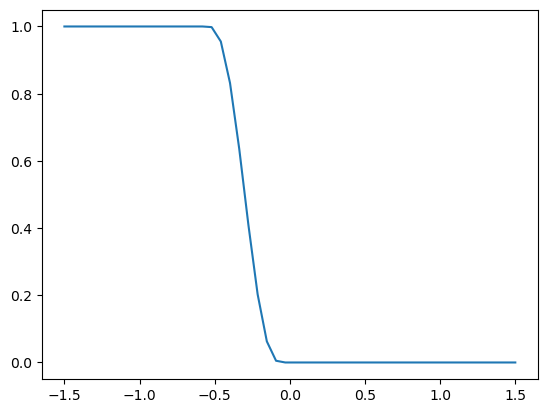

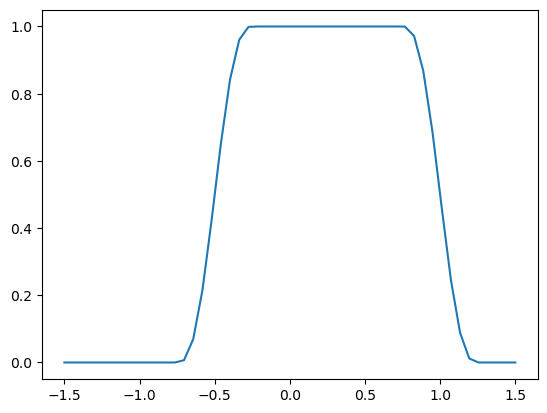

In [33]:
c1 = - 0.16171875
def func_dx(x, a=0):
    res = (c1 + 1/5*(x-a)**5 - (x-a)**4 + 47/24*(x-a)**3 - 15/8*(x-a)**2 + 225/256*(x-a))/0.001041666666667
    return res

c2 =  0.1627604166666665
def func_sx(x, a=0):
    res = (c2 + 1/5*(x-a)**5 + (x-a)**4 + 47/24*(x-a)**3 + 15/8*(x-a)**2 + 225/256*(x-a))/0.001041666666666
    return res

def pou(x, a=-1, b=1):
    return tf.clip_by_value(1-func_dx(x, b-1), 0.0, 1.0) + tf.clip_by_value(func_sx(x, 1+a), 0.0, 1.0) - 1

def pou_dx(x, b=1, uno=1.5):
    return tf.clip_by_value(func_sx(x, b-1+uno), 0.0, 1.0)# + tf.clip_by_value(func_sx(x,uno), 0.0, 1.0)

def pou_sx(x, a=-1, uno=1.5):
    return tf.clip_by_value(1-func_dx(x, a+1-uno), 0.0, 1.0)

xx = np.linspace(-1.5, 1.5)

plt.plot(xx,pou_sx(xx, -1, 2-(1-0.3)))
plt.show()
plt.plot(xx, pou(xx, -0.5, 1))

[-1.         -0.33333333  0.33333333  1.        ]


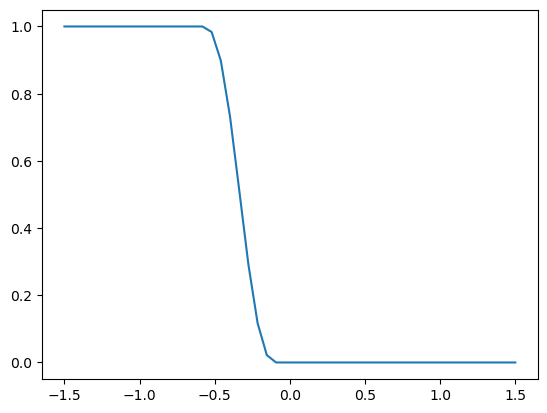

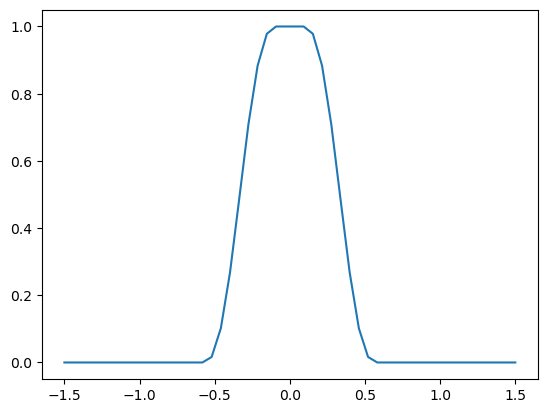

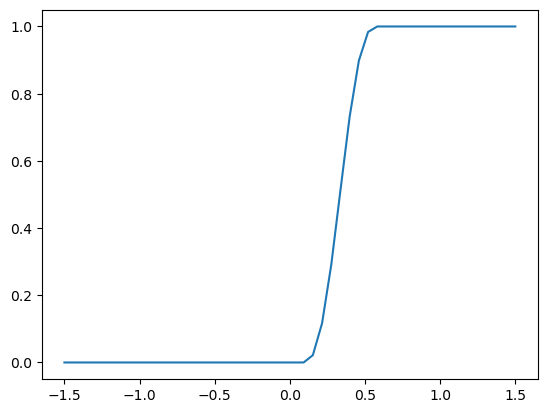

tf.Tensor(
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1.], shape=(50,), dtype=float64)


'\nfor i in range(npart):\n    if i == 0:\n        plt.plot(xx, pou_sx(xx, arr[0], 2-np.abs(arr[1])))\n        plt.show()\n    elif i == npart-1:\n        plt.plot(xx, pou_dx(xx, arr[-1], 2-np.abs(arr[-2])))\n        plt.show()\n    else:\n        plt.plot(xx,pou(xx,arr[i], arr[i+1]))\n        plt.show()\n'

In [36]:
a, b = -1, 1
total = b-a
npart = 3

def indicatrice(a,b,total,npart,i):
    if i == 0:
        return lambda x: pou_sx(x, a, total - (1- np.abs(b)))
    elif i == npart-1:
        return lambda x: pou_dx(x, b, total - (1- np.abs(a)))
    else:
        return lambda x: pou(x, a, b)

arr = np.linspace(a, b, npart+1)
print(arr)

ind = [indicatrice(arr[i], arr[i+1], total, npart, i) for i in range(npart)]


sum = np.zeros(xx.shape)
for j in range(npart):
    sum += ind[j](xx)
    plt.plot(xx, ind[j](xx))
    plt.show()
print(sum)

'''
for i in range(npart):
    if i == 0:
        plt.plot(xx, pou_sx(xx, arr[0], 2-np.abs(arr[1])))
        plt.show()
    elif i == npart-1:
        plt.plot(xx, pou_dx(xx, arr[-1], 2-np.abs(arr[-2])))
        plt.show()
    else:
        plt.plot(xx,pou(xx,arr[i], arr[i+1]))
        plt.show()
'''

[-1.  -0.5  0.   0.5  1. ]
Compiling model...
'compile' took 0.000250 s



Training model...

Step      Train loss              Test loss               Test metric   
0         [6.59e+04, 3.75e+00]    [6.97e+04, 3.75e+00]    [1.55e+00]    
58        [1.58e-02, 1.38e-04]    [5.46e-01, 1.38e-04]    [2.18e-02]    

Best model at step 58:
  train loss: 1.59e-02
  test loss: 5.47e-01
  test metric: [2.18e-02]

'train' took 19.021200 s

Saving loss history to c:\Users\Marco\Documents\GitHub\pacs\code\my_ex\loss.dat ...
Saving training data to c:\Users\Marco\Documents\GitHub\pacs\code\my_ex\train.dat ...
Saving test data to c:\Users\Marco\Documents\GitHub\pacs\code\my_ex\test.dat ...


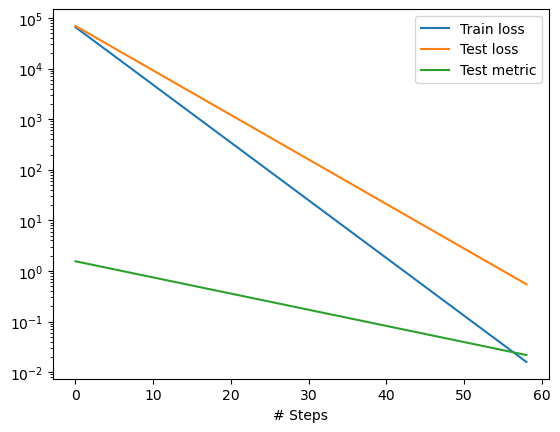

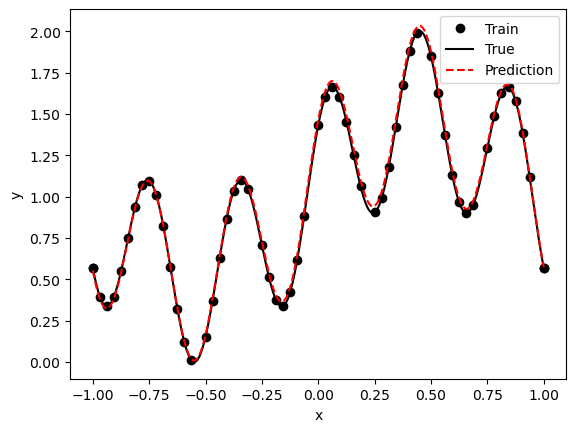

In [47]:
a, b = -1, 1
total = b-a
npart = 4
pi = np.pi

def indicatrice(a,b,total,npart,i):
    if i == 0:
        return lambda x: pou_sx(x, a, total - (1-np.abs(b)))
    elif i == npart-1:
        return lambda x: pou_dx(x, b, total - (1-np.abs(a)))
    else:
        return lambda x: pou(x, a, b)

arr = np.linspace(a, b, npart+1)
print(arr)

ind = [indicatrice(arr[i], arr[i+1], total, npart, i) for i in range(npart)]

def pde(x, y):
    dy_xx = dde.grad.hessian(y, x)
    # Use tf.sin for backend tensorflow.compat.v1 or tensorflow
    #return -dy_xx - np.pi ** 2 * tf.sin(np.pi * x)
    return -dy_xx - 13*pi**2*tf.sin(3*pi*x + 3*pi/20)*tf.cos(2*pi*x + pi/10) - 12*pi**2*tf.cos(3*pi*x + 3*pi/20)*tf.sin(2*pi*x + pi/10)

def boundary(x, on_boundary, npart=1):
    return on_boundary

def func(x):
    #return np.sin(np.pi * x)
    return np.sin(3*pi*x + 3*pi/20)*np.cos(2*pi*x + pi/10) + 1

geom = dde.geometry.Interval(a, b)
bc = dde.icbc.DirichletBC(geom, func, boundary)
data = dde.data.PDE(geom, pde, bc, 56, 2, solution=func, num_test=500)

M =500
layer_size = [1] + [M]  +  [1]

activation = ["sin", 'linear']

initializer = "Glorot uniform"

R = 20
net = dde.nn.partioned_random_FNN(layer_size, activation, initializer, npart, ind, Rm=R, b=R/10)

model = dde.Model(data, net)
#wei = np.ones(2)
#wei[0] = 0
#wei = tf.convert_to_tensor(wei, dtype=tf.float32)

model.compile("L-BFGS", lr=0.001, metrics=["l2 relative error"])#, loss_weights=wei)

losshistory, train_state = model.train(iterations=20000)

dde.saveplot(losshistory, train_state, issave=True, isplot=True)